In [94]:
import matplotlib

import argparse
import os
import random
import cv2

import matplotlib.pyplot as plt
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
from skimage import exposure, io, transform
import csv


In [2]:
def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []

	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)

	# loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))

		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]

		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)
		
		data.append(image)
		labels.append(int(label))

	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)

	# return a tuple of the data and labels
	return (data, labels)

In [7]:
dataset_path = "./my_gtsrb"

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]


trainPath = os.path.sep.join([dataset_path, "Train.csv"])
testPath = os.path.sep.join([dataset_path, "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(dataset_path, trainPath)
(testX, testY) = load_split(dataset_path, testPath)

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images


/tmp/ipykernel_162904/3466247126.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images


In [61]:
labelToText = {
    0: "Limite de Velocidade (30km/h)",
    1: "Pare",
    2: "Não entre",
    3: "Estrada em obras",
    4: "Pedestres",
    5: "Crianças",
    6: "Bicicletas",
    7: "Animais selvagens",
    8: "Siga em frente",
    9: "Mantenha a direita",
    10: "Mantenha a esquerda"
}

count_sigs = {}

for i in trainY:
    _class = labelToText[i]
    count_sigs[_class] = count_sigs.get(_class, 0) + 1

sorted_traffic_signs = dict(sorted(count_sigs.items(), key=lambda item: item[1], reverse=True))
sorted_traffic_signs

{'Limite de Velocidade (30km/h)': 2220,
 'Mantenha a direita': 2070,
 'Estrada em obras': 1500,
 'Siga em frente': 1200,
 'Não entre': 1110,
 'Animais selvagens': 780,
 'Pare': 780,
 'Crianças': 540,
 'Mantenha a esquerda': 300,
 'Bicicletas': 270,
 'Pedestres': 240}

In [92]:
sorted_traffic_signs = dict(sorted(count_sigs.items(), key=lambda item: item[1], reverse=True))

multi_factor = {}
highest_class_count = max(sorted_traffic_signs.values())

for i in sorted_traffic_signs.items():
    class_count = i[1]
    if class_count < highest_class_count:
        factor = round(highest_class_count / class_count, 1)
        if factor >= 1.5:
            multi_factor[i[0]] = round(factor)

multi_factor

{'Estrada em obras': 2,
 'Siga em frente': 2,
 'Não entre': 2,
 'Animais selvagens': 3,
 'Pare': 3,
 'Crianças': 4,
 'Mantenha a esquerda': 7,
 'Bicicletas': 8,
 'Pedestres': 9}

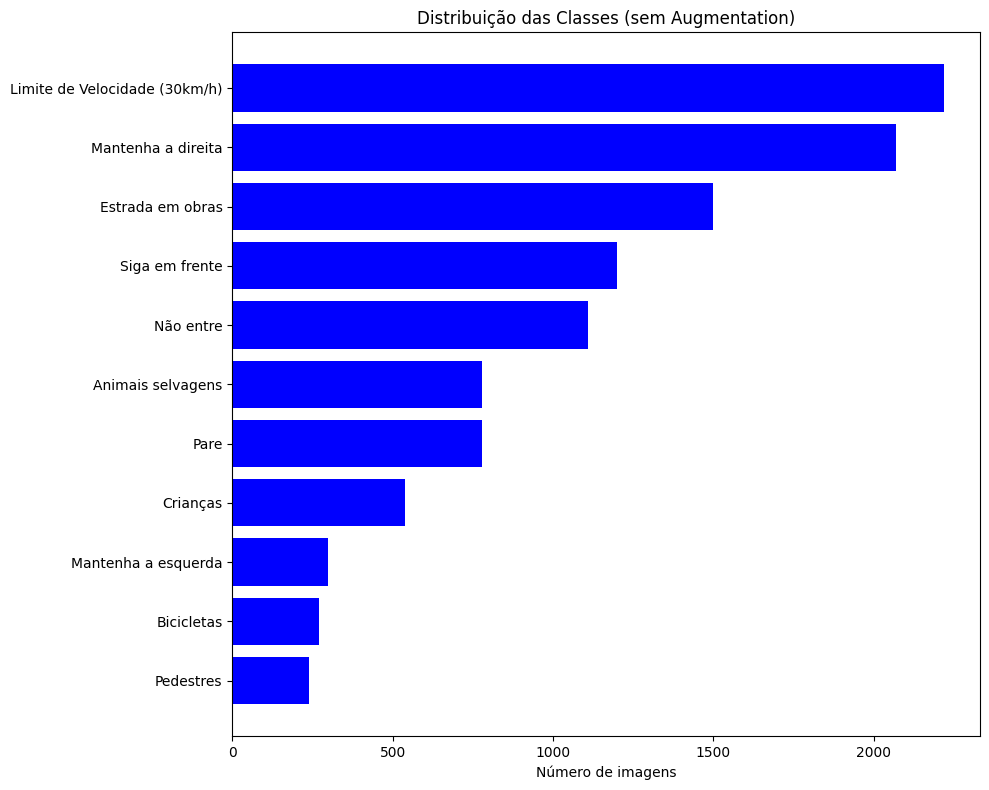

In [32]:
# Extract keys and values for plotting
categories = list(sorted_traffic_signs.keys())
counts = list(sorted_traffic_signs.values())

# Create the horizontal bar graph
plt.figure(figsize=(10, 8))
plt.barh(categories, counts, color='blue')
plt.xlabel('Número de imagens')
plt.title('Distribuição das Classes (sem Augmentation)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.tight_layout()

# Show the plot
plt.show()


In [98]:

# Define the augmentations pipeline
seq = iaa.Sequential([
    iaa.SomeOf((0, 2), [
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        ),
        iaa.Multiply((0.8, 1.2)),
        iaa.GaussianBlur(sigma=(0, 1.0)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.Grayscale(alpha=(0.0, 1.0))
    ]),
    iaa.Fliplr(0.5), # horizontal flips
], random_order=True)

def augment_images(images_np_array, labels, output_dir, augmentations=5):
    # Make sure output directory exists
    for label in list(set(labels)):
        label_dir = os.path.join(output_dir, "Train", str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
    
    for i, j in enumerate(zip(images_np_array, labels)):
        image, label = j[0], j[1]
        sign_name = labelToText[label]

        if sign_name in multi_factor:
            augmentations = multi_factor[sign_name]

            image_aug = [seq.augment_image(image) for _ in range(augmentations)]
            with open('Train_aug.csv', 'a', newline='') as file:
                for aug_idx, aug_image in enumerate(image_aug):
                    img_path = os.path.join("Train", str(label), f"{sign_name}_{i}_aug_{aug_idx}.png")
                    aug_path = os.path.join(output_dir, img_path)
                    io.imsave(aug_path, aug_image)
                    row = f"x,x,x,x,x,x,{label},{img_path}".split(',')
                    writer = csv.writer(file)
                    writer.writerow(row)
                    


# Assume 'images_np_array' is your NumPy array of images
# Example: images_np_array = np.array([...], dtype=np.uint8)

# Augment images and save them to the 'augmented_traffic_signs' directory
augment_images(trainX, trainY, 'augmented_traffic_signs')

/tmp/ipykernel_162904/2237593807.py:38: UserWarning: augmented_traffic_signs/Train/7/Animais selvagens_26_aug_1.png is a low contrast image
  io.imsave(aug_path, aug_image)
/tmp/ipykernel_162904/2237593807.py:38: UserWarning: augmented_traffic_signs/Train/7/Animais selvagens_26_aug_2.png is a low contrast image
  io.imsave(aug_path, aug_image)
/tmp/ipykernel_162904/2237593807.py:38: UserWarning: augmented_traffic_signs/Train/2/Não entre_145_aug_0.png is a low contrast image
  io.imsave(aug_path, aug_image)
/tmp/ipykernel_162904/2237593807.py:38: UserWarning: augmented_traffic_signs/Train/2/Não entre_145_aug_1.png is a low contrast image
  io.imsave(aug_path, aug_image)
/tmp/ipykernel_162904/2237593807.py:38: UserWarning: augmented_traffic_signs/Train/5/Crianças_181_aug_1.png is a low contrast image
  io.imsave(aug_path, aug_image)
/tmp/ipykernel_162904/2237593807.py:38: UserWarning: augmented_traffic_signs/Train/5/Crianças_181_aug_3.png is a low contrast image
  io.imsave(aug_path, aug

In [100]:
aug_path = "./augmented_traffic_signs"
test_path = "./my_gtsrb"

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]


trainPath = os.path.sep.join([aug_path, "Train_aug.csv"])
testPath = os.path.sep.join([test_path, "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(aug_path, trainPath)
(testX, testY) = load_split(test_path, testPath)

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images


/tmp/ipykernel_162904/3466247126.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images


In [101]:
count_sigs_aug = {}

for i in trainY:
    _class = labelToText[i]
    count_sigs_aug[_class] = count_sigs_aug.get(_class, 0) + 1

sorted_traffic_signs_aug = dict(sorted(count_sigs_aug.items(), key=lambda item: item[1], reverse=True))
sorted_traffic_signs_aug

{'Estrada em obras': 3000,
 'Siga em frente': 2400,
 'Pare': 2340,
 'Animais selvagens': 2340,
 'Não entre': 2220,
 'Limite de Velocidade (30km/h)': 2220,
 'Bicicletas': 2167,
 'Crianças': 2160,
 'Pedestres': 2160,
 'Mantenha a esquerda': 2100,
 'Mantenha a direita': 2070}

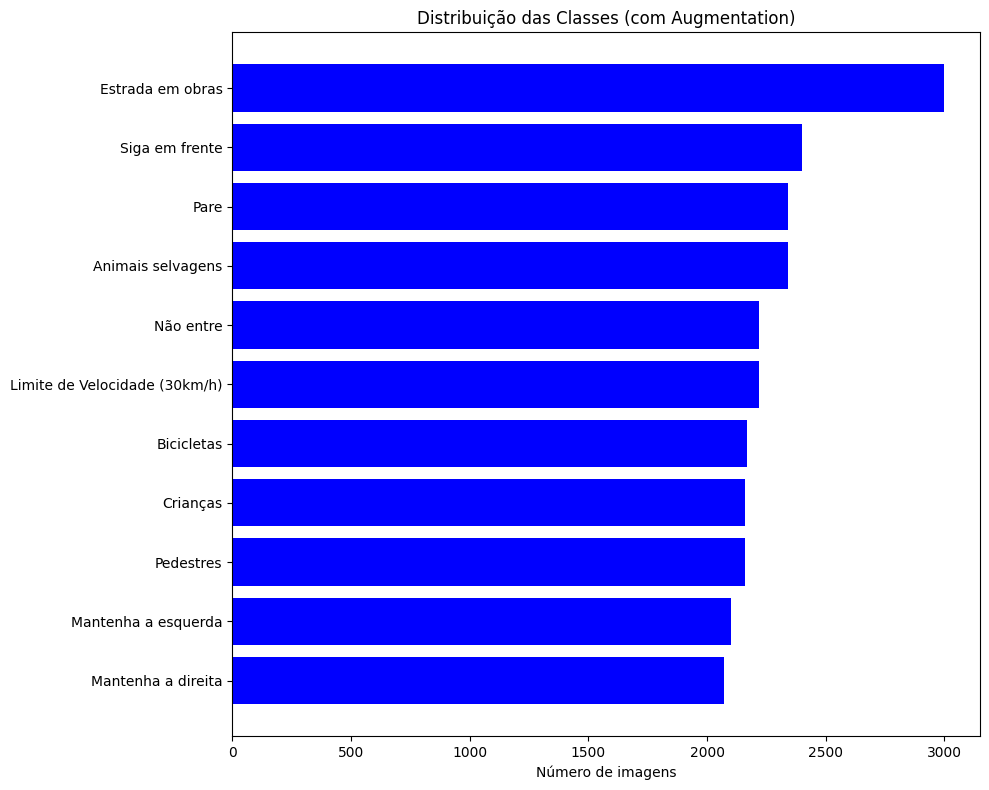

In [102]:
# Extract keys and values for plotting
categories = list(sorted_traffic_signs_aug.keys())
counts = list(sorted_traffic_signs_aug.values())

# Create the horizontal bar graph
plt.figure(figsize=(10, 8))
plt.barh(categories, counts, color='blue')
plt.xlabel('Número de imagens')
plt.title('Distribuição das Classes (com Augmentation)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.tight_layout()

# Show the plot
plt.show()
